In [10]:

import json
import numpy
import pandas as pd
from keras import losses
from keras import optimizers
from keras.callbacks import Callback
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk


In [11]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

stop_words = set(stopwords.words('english'))
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
import re

import matplotlib.pyplot as plt

numpy.random.seed(7)

[nltk_data] Downloading package wordnet to /Users/bsuthar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:

# GLOVE--EMBEDDING
def read_data(file_name):
    with open(file_name,'r') as f:
        word_vocab = set() # not using list to avoid duplicate entry
        word2vector = {}
        for line in f:
            line_ = line.strip() #Remove white space
            words_Vec = line_.split()
            word_vocab.add(words_Vec[0])
            word2vector[words_Vec[0]] = numpy.array(words_Vec[1:],dtype=float)
    print("Total Words in DataSet:",len(word_vocab))
    return word_vocab,word2vector

word_vocab,w2v = read_data('Glove/glove.twitter.27B.25d.txt')

Total Words in DataSet: 1193514


In [26]:

## While preprocessing total word count in corpus is stored
word_count = []


def preprocess(text):
    text = str(text.lower())

    # Remove all the special characters
    text = re.sub(r'\W', ' ', text)

    text = re.sub(r'[^a-zA-Z ]+', '', text)

    # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)

    # Substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    # Removing prefixed 'b'
    text = re.sub(r'^b\s+', '', text)

    text = word_tokenize(text)

    text = [word for word in text if word not in stop_words]



    word_net_lemmatizer = WordNetLemmatizer()

    text = [word_net_lemmatizer.lemmatize(word) for word in text]

    # ps = nltk.stem.PorterStemmer()
    #
    # text = [ps.stem(word) for word in text]

    #word_count.append(len(text))

    text = ' '.join(text)

    return text



In [14]:

df = pd.read_excel('VoicePOC-pain-level-training-data.xlsx')
none = df['NONE'].values
mild = df['MILD'].values
moderate = df['MODERATE'].values
severe = df['SEVERE'].values

appeneded = none + mild + moderate + severe
feature_none = []
feature_mild = []
feature_moderate = []
feature_severe = [] 


for i in range(len(none)):
    feature_none.append(0)
for i in range(len(none)):
    feature_mild.append(1)
for i in range(len(none)):
    feature_moderate.append(2)
for i in range(len(none)):
    feature_severe.append(3)
    
data_none = pd.DataFrame({'text':none, 'feature':feature_none})
data_mild = pd.DataFrame({'text':mild, 'feature':feature_mild} )
data_moderate = pd.DataFrame({'text':moderate, 'feature':feature_moderate})
data_severe = pd.DataFrame({'text':severe, 'feature':feature_severe}) 

data_frame = pd.concat([data_none,data_mild,data_moderate,data_severe])


In [15]:
data_frame.text = data_frame.text.apply(preprocess)

X = data_frame.text
y = data_frame.feature

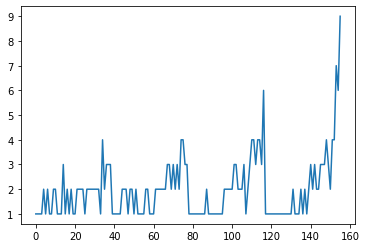

In [16]:

word_count = numpy.array(word_count)
max_length = 10

plt.plot(word_count)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_frame.text)

X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=max_length, padding='post')

num_words = len(tokenizer.word_index) + 1
embedding_matrix = numpy.zeros((num_words, 25))
# X,test_X

In [17]:

for word,i in tokenizer.word_index.items():
    try:

        embedding_vector = w2v[word]
        if embedding_vector is not None:
            print(i,word)
            embedding_matrix[i] = embedding_vector
    except:
        print(word,'Not in embeddings')


1 pain
2 feel
3 painful
4 level
5 nothing
6 time
7 amount
8 ignore
9 right
10 felt
11 feeling
12 noticeable
13 substantial
14 severe
15 think
16 zero
17 experience
18 mild
19 barely
20 easily
21 big
22 deal
23 tolerable
24 manageable
25 intense
26 considerable
27 activity
28 none
29 absent
30 discomfort
31 thing
32 moment
33 weak
34 faint
35 low
36 much
37 somewhat
38 easy
39 strong
40 lot
41 could
42 hardly
43 little
44 experienced
45 modest
46 horrible
47 unmanageable
48 quite
49 aware
50 extraordinary
51 high
52 move
53 non
54 existent
55 notice
56 free
57 missing
58 experiencing
59 recall
60 whatsoever
61 like
62 far
63 today
64 minimal
unsubstantial Not in embeddings
ignorable Not in embeddings
67 perceptible
68 bad
69 concerning
70 fairly
71 whole
72 complain
73 noticed
74 bit
75 small
76 bother
77 bearable
78 distracting
79 distressing
80 moderate
81 medium
82 bothersome
83 disturbing
84 pleasant
85 reasonably
86 tolerate
87 aggravating
88 annoying
89 mid
90 intolerable
91 terri

In [18]:
ACCUSRACY_THRESHOLD = .98

class Call_back(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('acc') > ACCUSRACY_THRESHOLD:
            print('Reached accuracy')
            self.model.stop_training = True
            
callback = Call_back()

In [23]:
embedding_model = Sequential()
embedding_model.add(Embedding(num_words, 25,weights=[embedding_matrix],trainable=True,input_length=X.shape[1]))
embedding_model.add(Bidirectional(LSTM(16)))
embedding_model.add(Dense(4, activation='sigmoid'))
embedding_model.compile(optimizer=optimizers.Adam(),
              loss=losses.sparse_categorical_crossentropy,
              metrics=['acc'])
embedding_model.summary()

history = embedding_model.fit(X, y, epochs=100, batch_size=5, callbacks=[callback])

W1015 11:19:11.890554 4478748096 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1015 11:19:11.894778 4478748096 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1015 11:19:11.904647 4478748096 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1015 11:19:11.905370 4478748096 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 25)            3400      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                5376      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 8,908
Trainable params: 8,908
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
156/156 [==============================] - 2s 10ms/step - loss: 1.3907 - acc: 0.2628
Epoch 2/100
156/156 [==============================] - 0s 2ms/step - loss: 1.3733 - acc: 0.3013
Epoch 3/100
156/156 [==============================] - 0s 2ms/step - loss: 1.3612 - acc: 0.3974
Epoch 4/100
156/156 [==============================] - 0s 2ms/step - loss: 1.3415 - acc: 0.5256
Epoch 5/100
156/156

156/156 [==============================] - 0s 2ms/step - loss: 0.1486 - acc: 0.9231
Epoch 79/100
156/156 [==============================] - 0s 2ms/step - loss: 0.1507 - acc: 0.9231
Epoch 80/100
156/156 [==============================] - 0s 2ms/step - loss: 0.1473 - acc: 0.9167
Epoch 81/100
156/156 [==============================] - 0s 2ms/step - loss: 0.1497 - acc: 0.9167
Epoch 82/100
156/156 [==============================] - 0s 2ms/step - loss: 0.1516 - acc: 0.9231
Epoch 83/100
156/156 [==============================] - 0s 2ms/step - loss: 0.1488 - acc: 0.9231
Epoch 84/100
156/156 [==============================] - 0s 2ms/step - loss: 0.1462 - acc: 0.9231
Epoch 85/100
156/156 [==============================] - 0s 2ms/step - loss: 0.1459 - acc: 0.9295
Epoch 86/100
156/156 [==============================] - 0s 2ms/step - loss: 0.1457 - acc: 0.9167
Epoch 87/100
156/156 [==============================] - 0s 2ms/step - loss: 0.1437 - acc: 0.9167
Epoch 88/100
156/156 [=====================

In [24]:
embedding_model.save('pain_level_training.h5')


In [30]:
val = 133
text = [preprocess('distracting')]

embeddings = tokenizer.texts_to_sequences(text)
embeddings = pad_sequences(embeddings, maxlen=max_length, padding='post')
prediction1 = embedding_model.predict(embeddings)

classes = {3:'Severe',2:'Moderate',0:'None',
           1:'Mild',}

print('Model prediction:',classes[prediction1.argmax()])



Model prediction: Moderate


In [ ]:

import json
json.dumps(tokenizer.word_index)
